In [676]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from matplotlib.pyplot import figure
import scipy
import copy

<h1>Analysis of the data</h1>

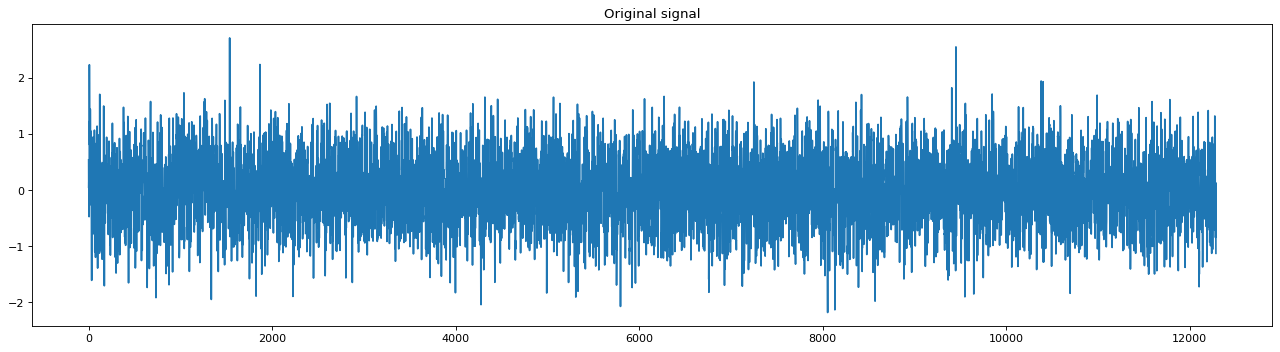

In [677]:
signal_content = sio.loadmat('wavelet_codeChallenge.mat')

signal = signal_content['signal'][:,0]
signalFIR = signal_content['signalFIR'][:,0]
signalMW = signal_content['signalMW'][:,0]
srate = signal_content['srate'][0][0]
seconds = len(signal) / srate
time =  np.arange(0, seconds, 1/srate)
hz = np.linspace(0,srate/2,int(np.floor(len(signal)/2)+1))


figure(figsize=(20, 5), dpi=80)
plt.plot(signal)
plt.title("Original signal")
plt.show()

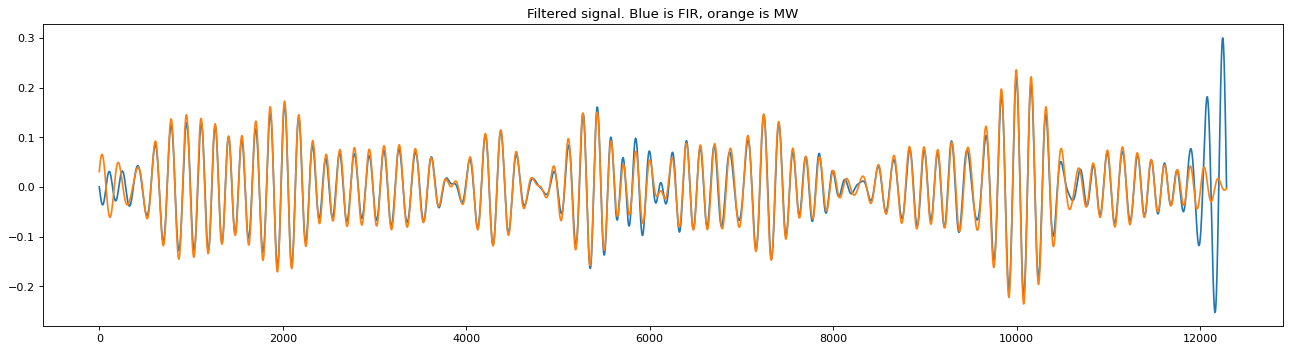

In [678]:
figure(figsize=(20, 5), dpi=80)
plt.plot(signalFIR)
plt.plot(signalMW)
plt.title("Filtered signal. Blue is FIR, orange is MW")
plt.show()

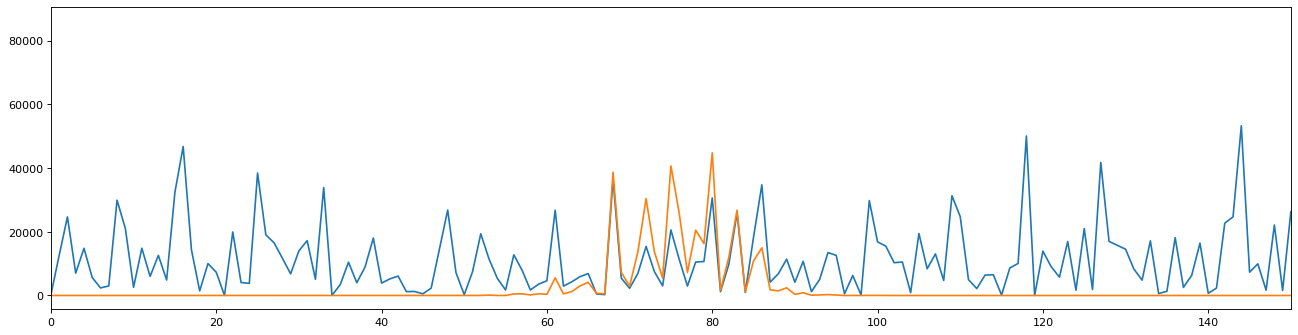

In [679]:
freqSignal = np.abs(scipy.fft.fft(signal))**2
freqFIR = np.abs(scipy.fft.fft(signalFIR))**2
freqMW = np.abs(scipy.fft.fft(signalMW))**2

figure(figsize=(20, 5), dpi=80)
plt.plot(freqSignal)
# plt.plot(freqFIR)
plt.plot(freqMW)
plt.xlim(0,150)
plt.show()

In [680]:
print(signal.shape)
print(time.shape)
print(srate)

(12288,)
(12288,)
2048


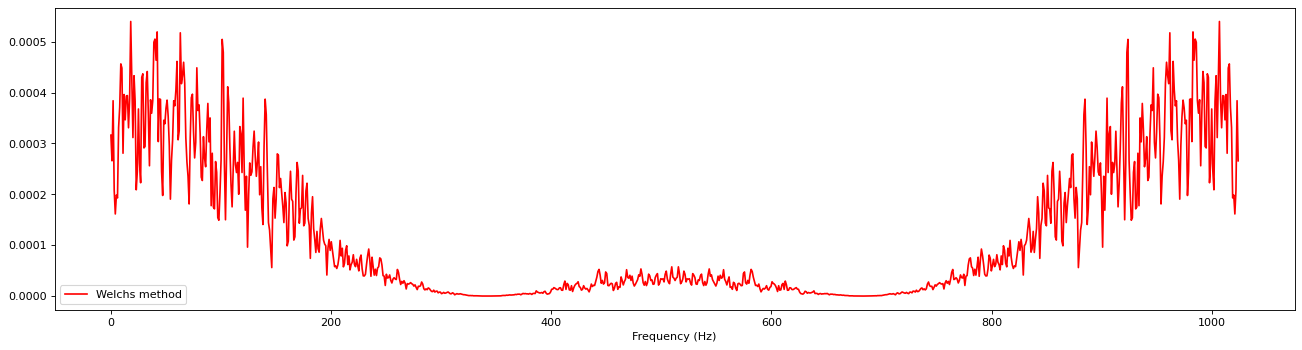

(11,)
(1024,)
(11, 1024)
(1024, 11)


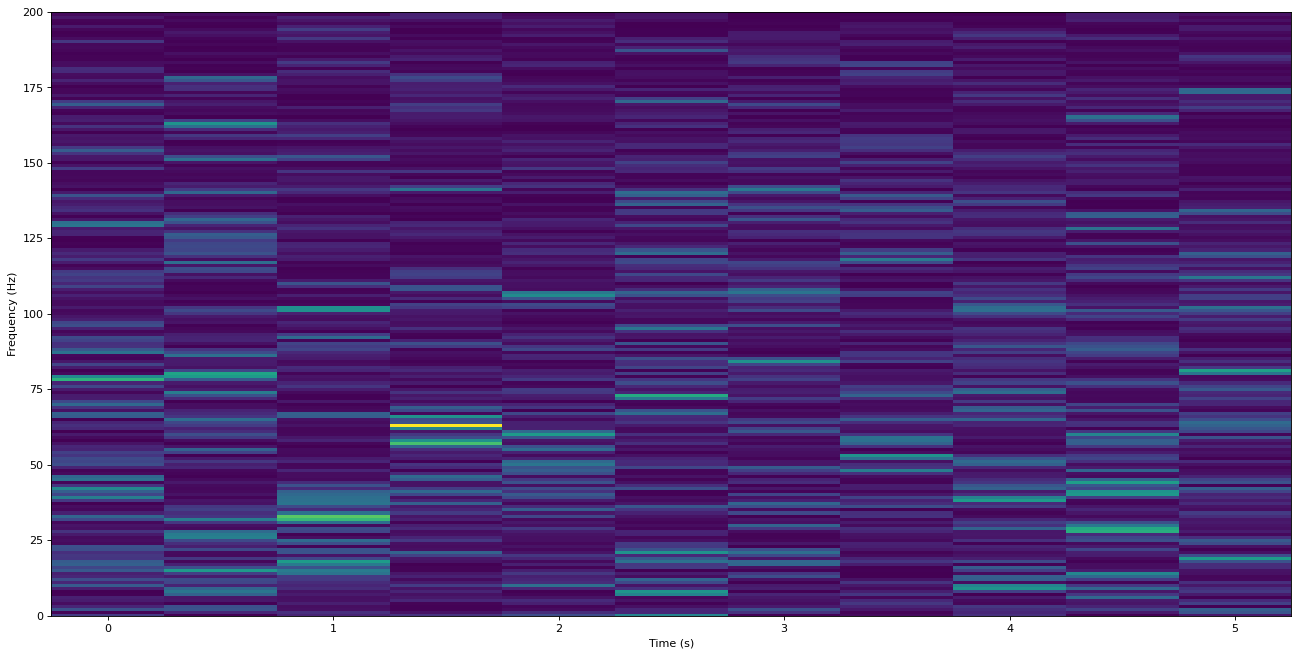

In [681]:
# Welch 
winlength = int(0.5*srate)

winOnsets = np.arange(0, int(len(time)-winlength), int(winlength))

hzW = np.linspace(0,srate/2, int(np.floor(winlength)))

hannWin = 0.5 - np.cos(2*np.pi*np.linspace(0,1,int(winlength)))/2

signalPow = np.zeros(len(hzW))

listOfFTs = []

matrix = np.zeros((len(winOnsets),len(hzW)))

for wi in range(0, len(winOnsets)):
    dataChunk = signal[winOnsets[wi]:winOnsets[wi]+winlength]
    dataChunk = dataChunk * hannWin
    tmpPow = np.abs(scipy.fft.fft(dataChunk)/winlength)**2

    matrix[wi,:] = matrix[wi,:] + tmpPow[0:len(hzW)]
    
    signalPow = signalPow + tmpPow[0:len(hzW)]

signalPow = signalPow / len(winOnsets)

# plotting
figure(figsize=(20, 5), dpi=80)
plt.plot(hzW,signalPow,'r',label='Welch''s method')
# plt.xlim([0,40])
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()

times = np.arange(0,5.5,0.5)

print(times.shape)
print(hzW.shape)
print(matrix.shape)
print(np.transpose(matrix).shape)

figure(figsize=(20, 10), dpi=80)
plt.pcolormesh(times, hzW, np.transpose(matrix))
plt.ylim([0,200])
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.show()

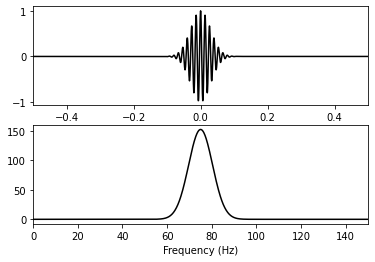

In [682]:
# Signal should be narrow band filtered for freqnecies 60Hz - 90Hz

# Create the wavelet

# ffreq = 75
# fwhm = .07
# wavtime = np.arange(-3,3,1/srate) # time vector for it. Same sampling rate as the signal.

# # Create the wavelet

# morway = np.cos(2*np.pi*ffreq*wavtime) * np.exp(-(4*np.log(2)*wavtime**2)/fwhm**2)

# wavehz = np.linspace(0, srate/2, int(np.floor(len(wavtime)/2)+1))
# morwayX = np.abs(scipy.fft.fft(morway))**2

# figure(figsize=(20, 5), dpi=80)
# plt.plot(wavtime,morway,'k')
# plt.xlim([-.5,.5])
# plt.xlabel('Time (sec.)')
# plt.show()

# figure(figsize=(20, 5), dpi=80)
# plt.plot(wavehz,morwayX[:len(wavehz)],'k')
# plt.xlim([0,ffreq*2])
# plt.xlabel('Frequency (Hz)')
# plt.show()

ffreq = 75  # filter frequency in Hz
fwhm  = .07 # full-width at half-maximum in seconds
wavtime = np.arange(-3,3,1/srate) # wavelet time vector (same sampling rate as signal!)

# create the wavelet
morwav = np.cos(2*np.pi*ffreq*wavtime) * np.exp( -(4*np.log(2)*wavtime**2) / fwhm**2 )


# amplitude spectrum of wavelet
# (note that the wavelet needs its own hz because different length)
wavehz  = np.linspace(0,srate/2,int(np.floor(len(wavtime)/2)+1))
morwavX = 2*np.abs(scipy.fft.fft(morwav))


# plot it!
plt.subplot(211)
plt.plot(wavtime,morwav,'k')
plt.xlim([-.5,.5])
plt.xlabel('Time (sec.)')

plt.subplot(212)
plt.plot(wavehz,morwavX[:len(wavehz)],'k')
plt.xlim([0,ffreq*2])
plt.xlabel('Frequency (Hz)')
plt.show()

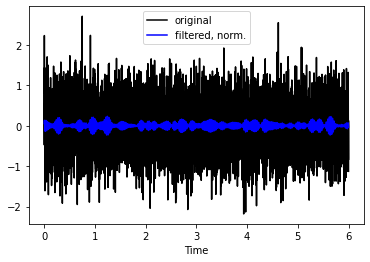

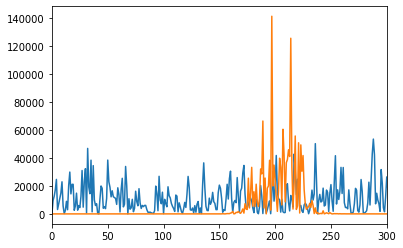

In [689]:
# apply the wavelet with convolution of the signal

# nConv = len(signal) + len(wavtime) - 1

# signalX = scipy.fft.fft(signal,nConv)
# # get freqnecies again but of specifc length
# morwayX = scipy.fft.fft(morway, nConv)

# # normalize the wavelet first to range the y value form 0 to 1
# morwayX = morwayX/np.abs(np.max(morwayX))
# morwayX = morwayX*200

# # plt.plot(signalX)
# plt.plot(morwayX)
# plt.xlim(0,1000)
# # plt.xlim([0,ffreq*2])
# plt.show()

# # get the filtered signal
# convres = scipy.fft.ifft(morwayX * signalX)
# halfw = int( np.floor(len(wavtime)/2) )
# convres = np.real( convres[halfw:-halfw+1] )
# # get the frequency range again
# convresX = np.abs(scipy.fft.fft(convres))**2

nConv = len(signal) + len(wavtime) - 1
halfw = int( np.floor(len(wavtime)/2) )

# spectrum of wavelet
morwavX = scipy.fft.fft(morwav,nConv)

# now normalize in the frequency domain
## note: ensure we're taking the magnitude of the peak; 
#  I didn't explain this in the video but it ensures normalization by
#  the magnitude and not the complex value.
morwavX = morwavX / np.abs(np.max(morwavX))
# also equivalent:
morwavX = (np.abs(morwavX)/max(np.abs(morwavX))) * np.exp(1j*np.angle(morwavX))

# now for the rest of convolution
convres = scipy.fft.ifft( morwavX * scipy.fft.fft(signal,nConv) )
convres = np.real( convres[halfw:-halfw+1] )


# time domain
plt.plot(time,signal)
plt.plot(time,convres)
plt.legend()
plt.xlabel('Time')
plt.show()

# frequency domain
convresX = 2*np.abs(scipy.fft.fft(convres))
plt.plot(np.abs(signal)**2)
plt.plot(np.abs(convresX)**2)
plt.plot(np.abs(convresX)**2)
plt.xlim(0, 300)
plt.show()

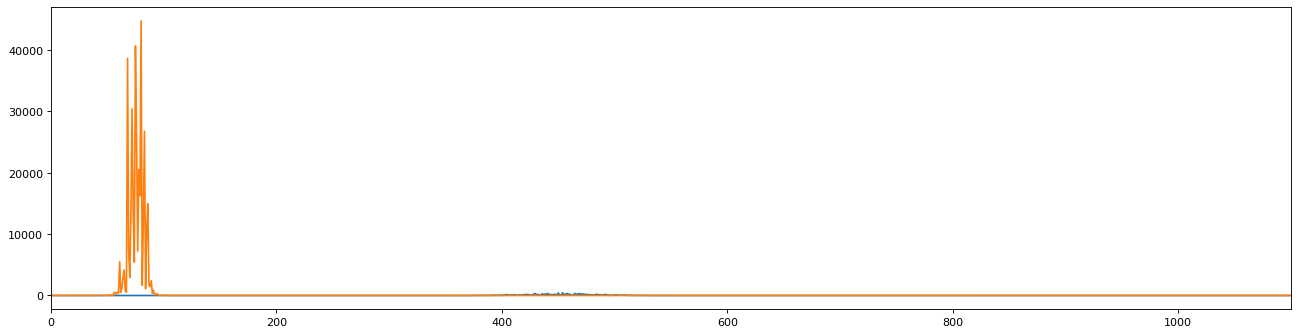

In [684]:
figure(figsize=(20, 5), dpi=80)
plt.plot(convresX)
plt.plot(freqMW)
plt.xlim(0,1100)
plt.show()

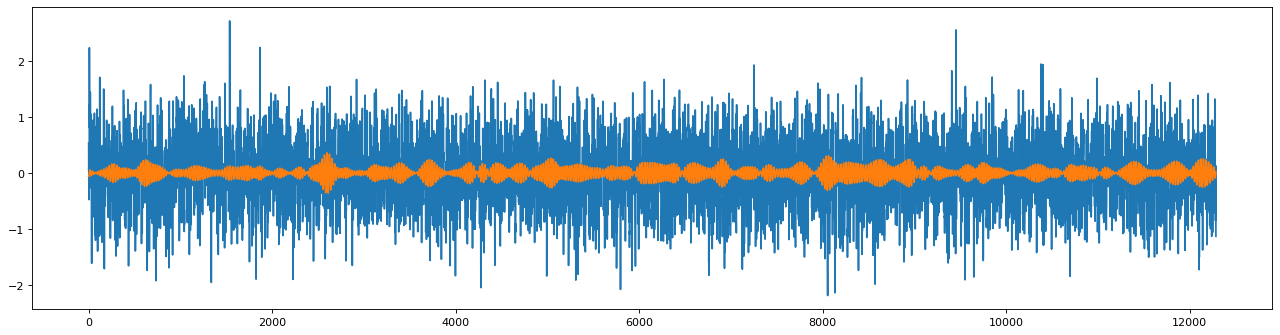

In [685]:
figure(figsize=(20, 5), dpi=80)
plt.plot(signal)
plt.plot(convres)
# plt.xlim(0,1100)
plt.show()

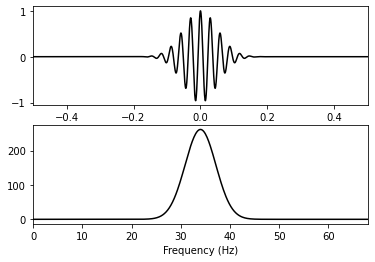

In [686]:
ffreq = 34  # filter frequency in Hz
fwhm  = .12 # full-width at half-maximum in seconds
wavtime = np.arange(-3,3,1/srate) # wavelet time vector (same sampling rate as signal!)

# create the wavelet
morwav = np.cos(2*np.pi*ffreq*wavtime) * np.exp( -(4*np.log(2)*wavtime**2) / fwhm**2 )


# amplitude spectrum of wavelet
# (note that the wavelet needs its own hz because different length)
wavehz  = np.linspace(0,srate/2,int(np.floor(len(wavtime)/2)+1))
morwavX = 2*np.abs(scipy.fft.fft(morwav))


# plot it!
plt.subplot(211)
plt.plot(wavtime,morwav,'k')
plt.xlim([-.5,.5])
plt.xlabel('Time (sec.)')

plt.subplot(212)
plt.plot(wavehz,morwavX[:len(wavehz)],'k')
plt.xlim([0,ffreq*2])
plt.xlabel('Frequency (Hz)')
plt.show()